# How To Run This Notebook

1. Run all cells until "Graphing Usage" section. 
2. Load data by calling `load_df(path)`, where `path` is filepath to csv file.
3. Get r_bg, r_np, data by calling `r_bg, r_np, df = cleanup(df)`.
4. Optionally remove outliers by calling `df = remove_outliers(df)`.
5. Graph results by calling `graph_firstRun(df, ["fg"])` where `["fg"]` can be replaced with any subset (e.g. `["bg", "np"]`) or omitted entirely (e.g. `graph_firstRun(df)`) to graph all three.

### Imports 

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# import csv 
# path = path to csv file
# reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
def load_df(path):
    df = pd.read_csv(path, header=None)
    return df

### Data Preprocessing Helper Functions 
(for datasets with schema (site, rank, r_time, r_time_eq, case, label, r_bg, r_np) only)

In [3]:
# makes new rows with clean values, e.g. 'rank=1' --> '1'
# reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
def row_cleanup(df):
    df['site'] = df[0].apply(lambda x: x[5:])
    df['rank'] = df[1].apply(lambda x: x[5:])
    df['r_time'] = df[2].apply(lambda x: x[7:])
    df['html_parsing_time'] = df[3].apply(lambda x: x[11:])
    df['label'] = df[5].apply(lambda x: x[6:])
    df['r_bg'] = df[6].apply(lambda x: x[5:])
    df['r_np'] = df[7].apply(lambda x: x[5:])
    
    return df

In [4]:
# drops unnecessary columns, converts to numeric, and gets rid of negatives 
# references:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
def col_cleanup(df):
    # drop cols
    df_drop = df.drop(columns=[0, 1, 2, 3, 4, 5, 6, 7, 'r_bg', 'r_np'])
    # convert to numeric types
    df = df_drop.astype({'rank':'float', 'r_time':'float', 'html_parsing_time':'float'})
    # get rid of negatives
    df['html_parsing_time'] = abs(df['html_parsing_time'])
    
    return df

In [5]:
# cleans up dataset and returns baseline vals and clean dataframe
# reference: https://pandas.pydata.org/docs/reference/api/pandas.unique.html
def cleanup(df):
    
    df = row_cleanup(df)
    r_bg = float(df['r_bg'].unique()[0])
    r_np = float(df['r_np'].unique()[0])
    df = col_cleanup(df)
    
    return r_bg, r_np, df

In [6]:
# removes outliers
# references: 
# https://online.stat.psu.edu/stat200/lesson/3/3.2
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
def remove_outliers(df):
    Q1 = df.describe().iloc[4, 1]
    Q3 = df.describe().iloc[6, 1]
    IQR = Q3 - Q1

    df_filtered = df[df['r_time'] < (Q3 + 1.5*IQR)]
    df_filtered = df_filtered[df_filtered['r_time'] > (Q1 - 1.5*IQR)]
    return df_filtered

### Confidence Intervals (for getting DELTA)

In [27]:
# returns the confidence intervals, which is the threshold equivalent to DELTA
# inputs: dataframe, label (e.g. 'bg', 'np'), confidence level
# output: confidence interval of form [lower_bound, upper_bound]
# references:
# https://www.ncl.ac.uk/webtemplate/ask-assets/external/maths-resources/statistics/hypothesis-testing/hypothesis-testing-with-the-normal-distribution.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
def get_confidence_interval(df, label, confidence=0.99):
    
    df = df[df['label'] == label]
    mean = df['r_time'].mean()
    std = df['r_time'].std()
    
    interval = st.norm.interval(confidence=confidence, loc=mean, scale=std)
    return interval

### Get data for SVM: fg (1) vs np (0)

In [39]:
# removes bg and makes a binary label column 
def get_svm1_df(df):
    df_svm = df[df["label"] != 'bg']
    
    svm_label = (df_svm['label'] == 'fg')
    df_svm['svm_label'] = svm_label
    df_svm = df_svm.astype({'svm_label':'int'})
    
    return df_svm

In [40]:
# returns training and testing splits
def get_splits(df, x1, x2):
    X_pd = pd.DataFrame()
    X_pd[x1] = df[x1]
    X_pd[x2] = df[x2]
    X = X_pd.to_numpy()
    y = df['svm_label'].to_numpy()
    
    # get training and testing sets
    # 80% train, 20% test
    size = len(df)
    
    split_idx = (size // 5) * 4
    indices = [i for i in range(size)]
    random.shuffle(indices)
    X_train = X[indices[:split_idx]]
    y_train = y[indices[:split_idx]]
    X_test = X[indices[split_idx:size]]
    y_test = y[indices[split_idx:size]]
    
    return X_train, y_train, X_test, y_test
    

In [41]:
def get_svm1_splits(df):
    
    df_svm = get_svm1_df(df)
    X_train, y_train, X_test, y_test = get_splits(df_svm, 'r_time', 'html_parsing_time')
    
    return X_train, y_train, X_test, y_test

In [42]:
X_train, y_train, X_test, y_test = get_svm1_splits(df)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(48, 2) (48,) (12, 2) (12,)


C:\Users\Angel\AppData\Local\Temp/ipykernel_4980/2173550911.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_svm['svm_label'] = svm_label


### Make SVM

In [43]:
# make classifier
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm_case2 = SVC(kernel='linear', random_state=0)
svm_case2.fit(X_train, y_train)

train_pred = svm_case2.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print('Training Accuracy:', "{:.3f}".format(train_acc))

test_pred = svm_case2.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print('Testing Accuracy:', "{:.3f}".format(test_acc))

Training Accuracy: 0.979
Testing Accuracy: 1.000


### Graphs

In [33]:
# graphs rank vs. r_time
# inputs: 
    # df: dataframe 
    # types: list of types to graph, e.g. ["fg"], ["bg", "fg"]. Order does not matter, but don't use duplicates.
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
    # title: title of graph
    # confidence: whether to show confidence intervals (only valid if types contains both "bg" and/or "np")
def graph_firstRun(df, types=[], height=15, width=4, xlim=(0, 0.8), title="", confidence=False):
    
    # sets height and width
    # reference: https://www.statology.org/seaborn-figure-size/
    sns.set(rc={"figure.figsize":(height, width)}) 
    
    # take subset if needed
    if len(types) != 0:
        new_df = pd.DataFrame()
        for ele in types:
            subset = df[df['label'] == ele]
            new_df = pd.concat([new_df, subset])
        df = new_df 
        
    # graph
    # references: 
    # https://seaborn.pydata.org/generated/seaborn.scatterplot.html
    # https://www.statology.org/seaborn-axis-labels/
    # https://www.geeksforgeeks.org/how-to-change-axes-limits-in-seaborn/
    ax = sns.scatterplot(data=df, x='r_time', y='rank', hue='label', hue_order=['bg', 'fg', 'np'])
    ax.set(xlabel='Relative Loading Time',
           ylabel='Site Rank',
           title=title)
    ax.set_xlim(xlim[0], xlim[1])
    
    # show confidence intervals if needed
    # references: 
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html
    # https://www.statology.org/seaborn-add-line-to-scatterplot/
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle
    if confidence:
        if "bg" in types or len(types) == 0:
            bg_interval = get_confidence_interval(df, 'bg')
            print("bg interval: " + str(bg_interval))
            plt.axvline(bg_interval[0], color='blue', linestyle='--')
            plt.axvline(bg_interval[1], color='blue', linestyle='--')

        if "np" in types or len(types) == 0:
            np_interval = get_confidence_interval(df, 'np')
            print("np_interval: " + str(np_interval))
            plt.axvline(np_interval[0], color='green', linestyle='--')
            plt.axvline(np_interval[1], color='green', linestyle='--')


In [51]:
# graphs r_time vs. html_parsing
# inputs: 
    # df: dataframe 
    # height: height of graph
    # width: width of graph
    # xlim: limits of x-axis
def graph_case2(df, case=2, height=15, width=4, xlim=(0, 0.8), ylim=(-0.0001, 0.0016), svm=None):
    
    # sets height and width
    sns.set(rc={"figure.figsize":(height, width)}) 
    df = df[df["label"] != 'bg']
    
    # graph
    ax = sns.scatterplot(data=df, x='r_time', y='html_parsing_time', hue='label')
    ax.set(xlabel='Relative Loading Time',
           ylabel='HTML Parsing Time',
           title="Case 2: Relative Loading Time vs HTML Parsing Time")
    ax.set_xlim(xlim[0], xlim[1])
    
    # graph svm decision boundary
    if svm != None:
        # decision boundary has equation a1x1 + a2x2 + b = 0
        # references:
        # https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
        # https://seaborn.pydata.org/generated/seaborn.lineplot.html
        a = svm.coef_[0]           
        b = svm.intercept_[0]      
        x_points = np.linspace(xlim[0], xlim[1])    
        y_points = - (a[0]/a[1])*x_points - (b/a[1])
        sns.lineplot(x=x_points, y=y_points)
        ax.set_ylim(ylim[0], ylim[1])
        

## Graphing Usage 

In [10]:
# load df
df = load_df('results/fg_np_bg_top50_2.csv')

In [11]:
# get r_bg, r_np, and clean dataset
r_bg, r_np, df = cleanup(df)
print(r_bg)
print(r_np)
df

0.6424781788004189
1.2259677003854346


,site,rank,r_time,html_parsing_time,label
0,google.com,1.0,0.265919,0.000432,np
1,www.google.com,2.0,0.459362,0.000089,np
2,microsoft.com,3.0,0.500000,0.000098,np
3,data.microsoft.com,4.0,0.563565,0.000100,np
4,events.data.microsoft.com,5.0,0.584212,0.000107,np
...,...,...,...,...,...
85,ftl.netflix.com,26.0,0.183796,0.000066,bg
86,prod.ftl.netflix.com,27.0,0.203179,0.000000,bg
87,settings-win.data.microsoft.com,28.0,0.163390,0.000082,bg
88,www.googleapis.com,29.0,0.154579,0.000094,bg


In [12]:
# optional: remove outliers
df = remove_outliers(df)
df

,site,rank,r_time,html_parsing_time,label
0,google.com,1.0,0.265919,0.000432,np
1,www.google.com,2.0,0.459362,0.000089,np
2,microsoft.com,3.0,0.500000,0.000098,np
3,data.microsoft.com,4.0,0.563565,0.000100,np
4,events.data.microsoft.com,5.0,0.584212,0.000107,np
...,...,...,...,...,...
85,ftl.netflix.com,26.0,0.183796,0.000066,bg
86,prod.ftl.netflix.com,27.0,0.203179,0.000000,bg
87,settings-win.data.microsoft.com,28.0,0.163390,0.000082,bg
88,www.googleapis.com,29.0,0.154579,0.000094,bg


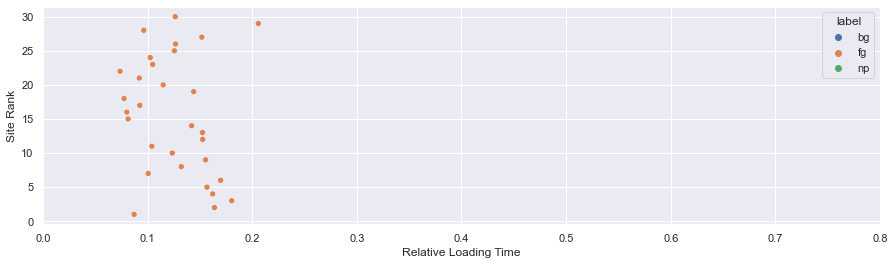

In [15]:
# graphing examples
graph_firstRun(df, ["fg"])

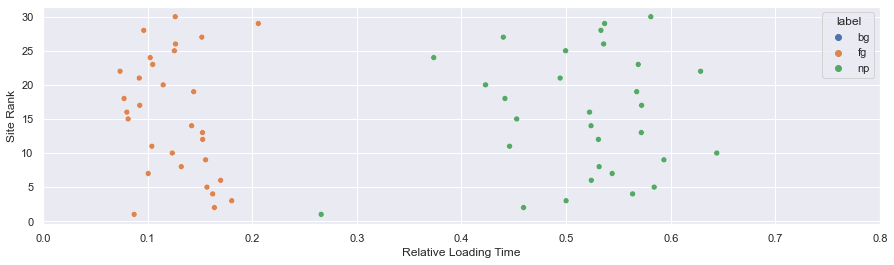

In [16]:
graph_firstRun(df, ["fg", "np"])

bg interval: (0.07312005743219156, 0.2720447079693591)
np_interval: (0.31426505364966517, 0.7160401429971497)


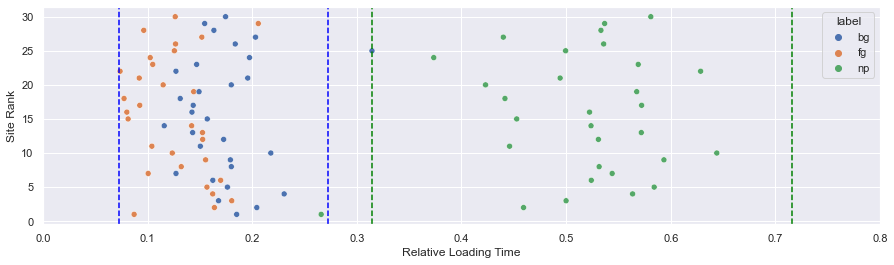

In [34]:
graph_firstRun(df, confidence=True)

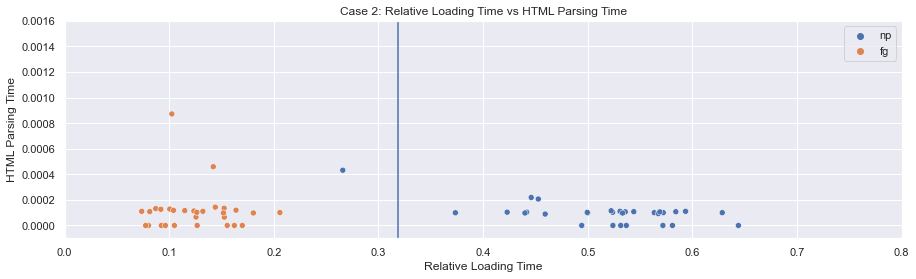

In [50]:
graph_case2(df, svm=svm_case2)

### Trying Different Datasets

In [194]:
# try Sihan's fg/bg and Mingzhi's np
fg = pd.read_csv('browser-security-sv1/results/frontend.csv', header=None)
bg = pd.read_csv('browser-security-sv1/results/backend.csv', header=None)
np = pd.read_csv('browser-security-sv1/results/np.csv', header=None)

fg['label'] = "fg"
bg['label'] = "bg"
np['label'] = "np"
fg

,0,1,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.016870,fg
296,297,0.008169,fg
297,298,0.019919,fg
298,299,0.066070,fg


In [172]:
sep_df = pd.concat([fg, bg, np])
sep_df

,0,1,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


In [173]:
sep_df = sep_df.rename(columns={1:'r_time', 0:'rank'})
sep_df

,rank,r_time,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


In [174]:
sep_dropped_df = sep_df[:899]
sep_dropped_df

,rank,r_time,label
0,1,0.019116,fg
1,2,0.008473,fg
2,3,0.013061,fg
3,4,0.009000,fg
4,5,0.011478,fg
...,...,...,...
294,295,0.111054,np
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np


<Axes: xlabel='r_time', ylabel='rank'>

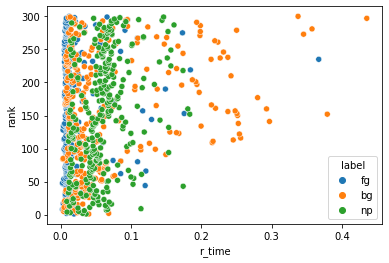

In [176]:
sns.scatterplot(data=sep_dropped_df, x='r_time', y='rank', hue='label')

In [178]:
sep_df_no_fg = pd.concat([bg, np]).rename(columns={1:'r_time', 0:'rank'})
sep_df_no_fg

,rank,r_time,label
0,1,0.040102,bg
1,2,0.068421,bg
2,3,0.023694,bg
3,4,0.026622,bg
4,5,0.004452,bg
...,...,...,...
295,296,0.076560,np
296,297,0.047068,np
297,298,0.084409,np
298,299,0.146430,np


<Axes: xlabel='r_time', ylabel='rank'>

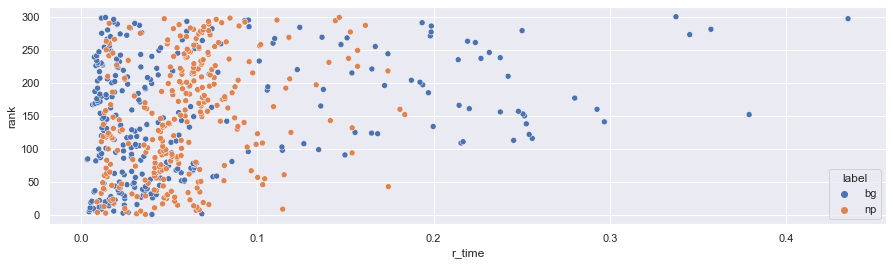

In [201]:
sns.set(rc={"figure.figsize":(15, 4)}) #width=3, #height=4
sep_df_no_fg = sep_df_no_fg[:599]
sns.scatterplot(data=sep_df_no_fg, x='r_time', y='rank', hue='label')